This notebook acquires data to measure the gain of the SiPM. It sets the overvoltage and then takes scope and MCA data with the Red Pitaya. The scope is setup to trigger on the LED.

In [1]:
import numpy as np
import time,datetime
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
plt.style.use('../../style.mplstyle')
import sys 
sys.path.append("../../devices")
sys.path.append("../../RedPitaya")
from datetime import datetime
import pyautogui
from ipywidgets import IntProgress
import importlib 
import matplotlib

In [2]:
#### set data taking parameters here #####

save_dir = "" ## name of directory to save, leave empty to use todays date as default
make_plots = True ## make diagnostic plots

breakdown_voltage = 27.38 ## Volts, breakdown to sweep keithley relative to
ov_list = np.arange(2, 7, 0.5) ## Volts, list of overvoltages to sweep

instr_to_sweep = 'keith' ## instrument to sweep over (must be 'keith' or 'synth')

red_pitaya_channel = 2 ## channel for the analog signal in the RP (1 or 2), used for MCA presumably after shaper
# for new synth -- would we change wf_chan_list to include more channels or does it need its own corresponding red_pitaya_channel?

In [3]:
## setup directories for saving data
def setup_save_dir(save_dir):

    if len(save_dir) > 0:
        path = "C:/Data/{}/".format(save_dir)
    else:
        date = datetime.today().strftime('%Y%m%d')
        subdir = ''
        path = "C:/Data/{}/{}/".format(date,subdir)
    
    if not os.path.exists(path):
        os.makedirs(path)
    
    return path

In [4]:
## import instrument control as needed
from pitaya import RedPitaya
from functiongenerator import AFG2225
from picoammeter import Keithley6487
from powersupply import NGE100
import redpitaya_mca as mca

In [5]:
nge = NGE100('USB0::0x0AAD::0x0197::5601.1414k03-100771::INSTR')
pico = Keithley6487('ASRL9::INSTR')
func = AFG2225('ASRL19::INSTR') ## first function generator
func2 = AFG2225('ASRL20::INSTR') ## second function generator

In [6]:
## turn on +/-12 Volts to power the cremat preamp
output_channel = 1 ## channel to turn on
output_voltage = 24 # Volts
nge.output(ch=output_channel, state=False)
nge.voltage(ch=output_channel, volt=output_voltage)
nge.output(ch=output_channel, state=True)

In [7]:
## setup the Keithley ahead of time and turn it on to the breakdown voltage so it starts ramping up
## will set the precise settings and loop through voltages later in the notebook

keithley_time_delay = 5 ## seconds, time to wait for the keithley to stabilize at a given voltage

if(instr_to_sweep == 'keith'):
    pico.voltage_source_state(0) ## turn off source
    pico.voltage_source_range(breakdown_voltage+np.max(ov_list)) ## set the range to accomodate the highest voltage needed
    pico.voltage(breakdown_voltage) ## set to breakdown
    pico.voltage_source_state(1) ## turn on source
    time.sleep(keithley_time_delay) ## wait for the voltage to ramp up

In [8]:
LED_dictionary = {
    'Blue': {
        'do_flash': True,
        'synth': func2,
        'channel': 1,
        "wavelength": 405
    },
    'UV': {
        'do_flash': True,
        'synth': func,
        'channel': 1,
        'wavelength': 310
    }
}

!!!! Before running this section, make sure to start the MCA app via the web interface !!!

In [28]:
def setup_mca_data(channel_to_use, integ_time=100, min_thresh=0):

    rp = mca.mca()
    ## chan = 1/2
    ## baseline is baseline level to subtract in MCA in bits (16 bit unsigned integer). Positive values from zero to 2^15-1
    ##   negative values from 2^16-1 to 2^15 
    ## integ_time is time per file in seconds
    ## min_thresh is threshold in bits at which to ignore peaks, set to non-zero to avoid collecting pedestal data

    rp.setup_mca(chan=channel_to_use, baseline_level=400, dec=32, integ_time = integ_time, min_thresh=min_thresh)
    rp.reset_histo(chan=channel_to_use)
    rp.start_histo(chan=channel_to_use)

    return rp

In [26]:
def collect_single_mca_file(red_pitaya_channel, time_per_file, mca_thresh, path, label):
        red_mca = setup_mca_data(channel_to_use=red_pitaya_channel-1, integ_time=time_per_file, min_thresh=mca_thresh) # 0 indexing for the channel, unlike above
        time.sleep(1) ## wait for setup to be ready -- otherwise it will read before buffer is full

        if(make_plots):
            fig=plt.figure()
            fig.patch.set_facecolor('white')
            hfig = display.display(fig, display_id=True)

        for i in range(int_time):
            dat = red_mca.read_histo_data(chan=1)
            #curr_time = red_mca.read_timer(chan=1)
            #print(curr_time)

            if(make_plots):
                plt.clf()
                plt.yscale('log')
                plt.plot(dat, color='k')
                plt.ylim(0.1,10000)
                plt.xlim(0,5000)
                hfig.update(fig)
            time.sleep(0.5) # adjust due to dead time

        if(make_plots):
            plt.show(fig)
        
        red_mca.save(dat, ch=red_pitaya_channel, tag='mca_keith_{:.2f}OV_{}_{}'.format(breakdown_voltage+ov, label, fidx), path=path)

        red_mca.close()

In [15]:
def setup_LED_flash(func, synth_channel, pulse_amplitude, LED_flashing_rate, pulse_width):
    # set the LED to flash the way we want them
    # function generator (func or func2), channel (1 or 2), voltage amplitude (V), LED flashing frequency (Hz), pulse width (ns): 1ns for gain measurements, 1 us for PDE 
    amplitude_offset = pulse_amplitude/2.0 ## V, offset to give positive going pulse

    func.set_output_onoff(synth_channel, 0) ## turn off channel
    func.set_wavetype(synth_channel, "PULS") 
    func.set_pulse_width(synth_channel, pulse_width) 
    func.set_frequency(synth_channel, LED_flashing_rate)
    func.set_amplitude(synth_channel, pulse_amplitude)
    func.set_offset(synth_channel, amplitude_offset)
    func.set_output_load(synth_channel, "HZ") ## make sure the channel is set for high impedance
    func.set_output_onoff(synth_channel, 1) ## turn on channel


In [16]:
setup_LED_flash(func2, 1, 10, 4e3, 1000)

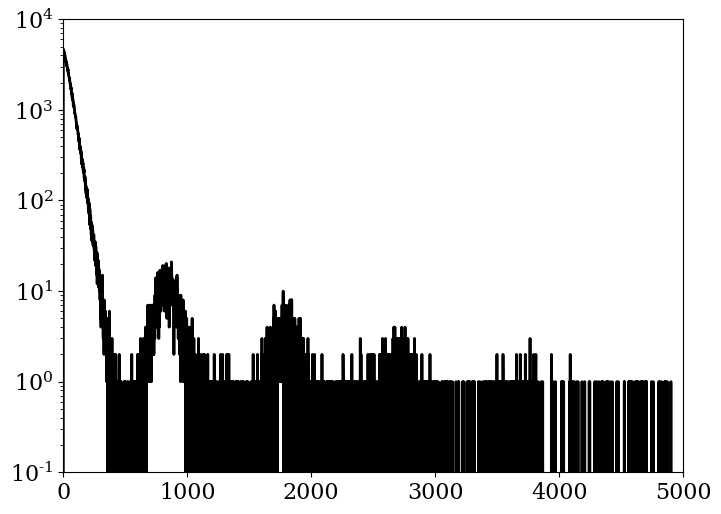

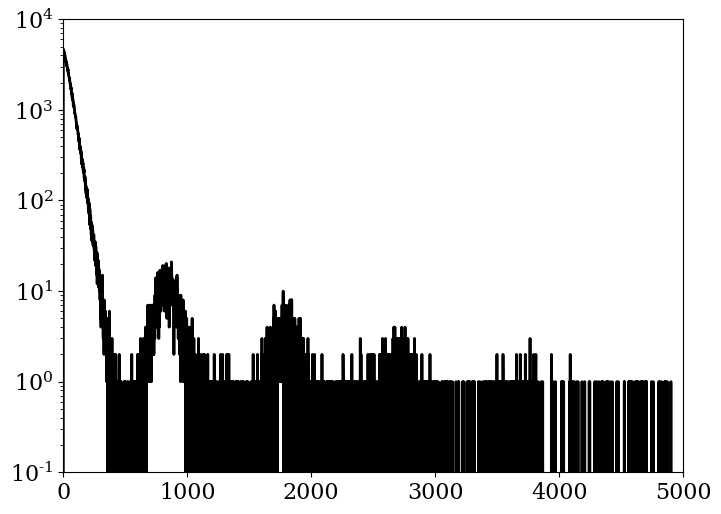

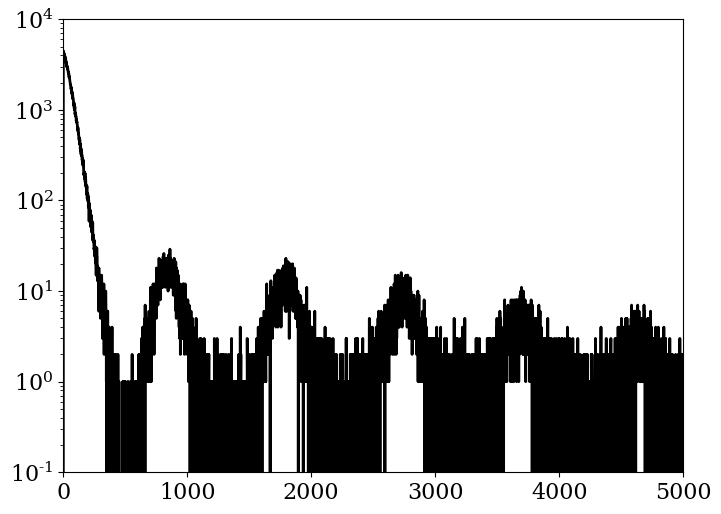

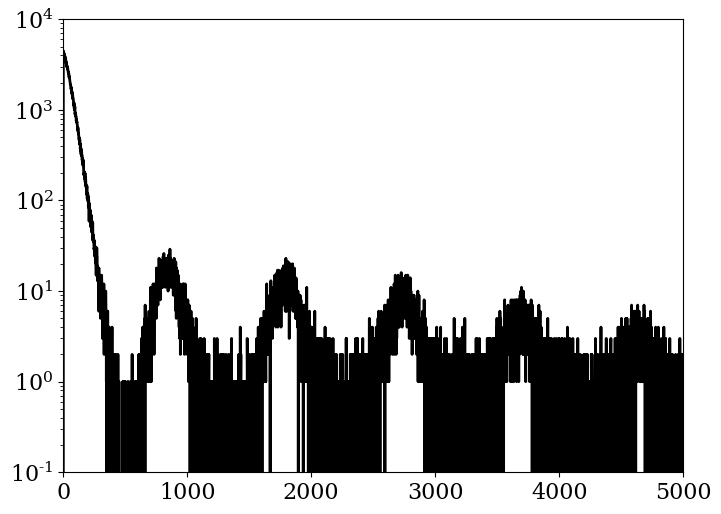

In [27]:
## Gain measurements ##

### should be two different settings for high SRS gain (gain data vs OV fully resolving 1 PE)
### and for low SRS gain (source data up to 100 PE)

## low gain data: SRS bandpass 100 Hz-300k Hz, gain = 20, unity gain shaper:  MCA params, dec=16, min_thresh=100 (cuts pedestal)
## high gain data: SRS bandpass 100 Hz -300k Hz, gain = 100, unity gain shaper:  MCA params, dec=16, min_thresh=500 (well sep from pedestal)

#######################
save_dir = r"20230208/Gains_100SRS/"

breakdown_voltage = 27.40 ## Volts, breakdown to sweep keithley relative to
ov_list = [4,] #np.arange(2.5, 7, 0.5) ## Volts, list of overvoltages to sweep #[4] is the OV for PDE measurement
#num_mca_events = 20000 ## number of events per file
time_per_file = 10 ## seconds ## for bv curve 10s per file ## for source 1 min per file
num_files_per_ov = 1 ## 1 for bv ## more for longer source data

mca_thresh = 0 ## minimum threshold [ADC bins] for mca to record pedestal

instr_to_sweep = 'keith' ## instrument to sweep over (must be 'keith' or 'synth')

## if desired, flash leds
## Columns are:
## Do flash (bool), synth, channel, wavelength
# LED_dict = [True, ]
#######################
pulse_amplitude = 10
LED_flashing_rate = 4e3
pulse_width = 500 ## 1 ns for gain measurements, 1 us for PDE

#######################

int_time = int(time_per_file) #int(num_mca_events/LED_flashing_rate)

## warn about overwriting files
path = setup_save_dir(save_dir)
#if( os.path.isfile(os.path.join(path, 'wavefms_keith_{:.2f}OV_{}.h5'.format(ov_list[0],0))) ):
#    resp = pyautogui.confirm("File already exists, overwrite?")
#    if( resp == "Cancel" ):
#        raise KeyboardInterrupt


## GAIN MEASUREMENT
# flash LEDs and collect data    
for i in LED_dictionary:
    setup_LED_flash(LED_dictionary[i]['synth'], LED_dictionary[i]['channel'], pulse_amplitude, LED_flashing_rate, pulse_width)

    for ov in ov_list:

        ## set keithley to desired voltage (assumes wired reverse biased, so positive voltages):
        if(instr_to_sweep == 'keith'):
            pico.voltage(breakdown_voltage + ov) 
            time.sleep(keithley_time_delay) ## wait for voltage to ramp up
        elif(instr_to_sweep == 'synth'):
            current_amp =  ov #/ov_list[-1] #normalize to go up to 1 volt max
            func.set_offset(synth_channel, current_amp/2)
            func.set_amplitude(synth_channel, current_amp)
        else:
            print("Warning, not sweeping -- set instr_to_sweep to '''keith''' or '''synth''' ")

        for fidx in range(num_files_per_ov):

            ## collect the source file (no LED flashes)
            collect_single_mca_file(red_pitaya_channel, time_per_file, mca_thresh, path, LED_dictionary[i]['wavelength'])

    LED_dictionary[i]['synth'].set_output_onoff(LED_dictionary[i]['channel'], 0)

In [ ]:
## PDE Measurements ##

ov_pde = 4 ## OV for PDE measurement
#num_mca_events = 20000 ## number of events per file
time_per_file = 60 ## seconds ## for bv curve 10s per file ## for source 1 min per file

mca_thresh = 0 ## minimum threshold [ADC bins] for mca to record pedestal

## leds
#######################
pulse_amplitude = 10
LED_flashing_rate = 4e3
pulse_width = 1000 ## 1 ns for gain measurements, 1 us for PDE
time_per_file_LED = 10
num_files_per_LED = 1

#######################
total_time = 7200 ## 2 hours (sec)
num_iterations = total_time/(time_per_file+2*time_per_file_LED)

int_time = int(time_per_file) #int(num_mca_events/LED_flashing_rate)

## warn about overwriting files
path = setup_save_dir(save_dir)
#if( os.path.isfile(os.path.join(path, 'wavefms_keith_{:.2f}OV_{}.h5'.format(ov_list[0],0))) ):
#    resp = pyautogui.confirm("File already exists, overwrite?")
#    if( resp == "Cancel" ):
#        raise KeyboardInterrupt

pico.voltage(breakdown_voltage + ov_pde) 
time.sleep(keithley_time_delay) ## wait for voltage to ramp up

for i in range(num_iterations):

    ## collect the source file (no LED flashes)
    collect_single_mca_file(red_pitaya_channel, time_per_file, mca_thresh, path, 'source')

    for i in LED_dictionary:
        setup_LED_flash(LED_dictionary[i]['synth'], LED_dictionary[i]['channel'], pulse_amplitude, LED_flashing_rate, pulse_width)
        for fidx in range(num_files_per_LED):
            collect_single_mca_file(red_pitaya_channel, time_per_file_LED, mca_thresh, path, LED_dictionary[i]['wavelength'])
        LED_dictionary[i]['synth'].set_output_onoff(LED_dictionary[i]['channel'], 0)

In [13]:
## creating function for measurement types (gain, pde)

save_dir = r"20230206/test/"
instr_to_sweep = 'keith' ## instrument to sweep over (must be 'keith' or 'synth')


## warn about overwriting files
path = setup_save_dir(save_dir)
#if( os.path.isfile(os.path.join(path, 'wavefms_keith_{:.2f}OV_{}.h5'.format(ov_list[0],0))) ):
#    resp = pyautogui.confirm("File already exists, overwrite?")
#    if( resp == "Cancel" ):
#        raise KeyboardInterrupt

def setup_measurement(meas_type):
    mca_thresh = 0 ## minimum threshold [ADC bins] for mca to record pedestal
    breakdown_voltage = 27.40 ## Volts, breakdown to sweep keithley relative to
    
    ## leds
    pulse_amplitude = 10
    LED_flashing_rate = 4e3

    if meas_type == 'gain':

        ov_list = np.arange(2.5, 7, 0.5) ## Volts, list of overvoltages to sweep
        time_per_file = 10 ## seconds ## for bv curve 10s per file
        int_time = int(time_per_file) #int(num_mca_events/LED_flashing_rate)
        num_files_per_ov = 1 ## 1 for bv ## more for longer source data
        
        # led
        pulse_width = 1

        for i in LED_dictionary:
            setup_LED_flash(LED_dictionary[i]['synth'], LED_dictionary[i]['channel'], pulse_amplitude, LED_flashing_rate, pulse_width)

            for ov in ov_list:

                ## set keithley to desired voltage (assumes wired reverse biased, so positive voltages):
                if(instr_to_sweep == 'keith'):
                    pico.voltage(breakdown_voltage + ov) 
                    time.sleep(keithley_time_delay) ## wait for voltage to ramp up
                elif(instr_to_sweep == 'synth'):
                    current_amp =  ov #/ov_list[-1] #normalize to go up to 1 volt max
                    func.set_offset(synth_channel, current_amp/2)
                    func.set_amplitude(synth_channel, current_amp)
                else:
                    print("Warning, not sweeping -- set instr_to_sweep to '''keith''' or '''synth''' ")

                for fidx in range(num_files_per_ov):

                    ## collect the source file (no LED flashes)
                    collect_single_mca_file(red_pitaya_channel, time_per_file, mca_thresh, path, int_time, ov, -1, )

            LED_dictionary[i]['synth'].set_output_onoff(LED_dictionary[i]['channel'], 0)

    if meas_type == 'pde':
        ov = 4 ## OV for PDE measurement
        time_per_file = 10 ## in seconds - for source 1 min per file
        int_time = int(time_per_file) #int(num_mca_events/LED_flashing_rate)

        ## leds
        pulse_width = 1000 ## in ns (1 us for PDE)
        time_per_file_LED = 10
        num_files_per_LED = 1

        #######################
        total_time = 30 #7200 ## in seconds -- total run time
        num_iterations = total_time/(time_per_file+2*time_per_file_LED)

        #######################
        pico.voltage(breakdown_voltage + ov) 
        time.sleep(keithley_time_delay) ## wait for voltage to ramp up

        for i in range(int(num_iterations)):

            ## collect the source file (no LED flashes)
            collect_single_mca_file(red_pitaya_channel, time_per_file, mca_thresh, path, int_time, ov, 1)

            for i in LED_dictionary:
                setup_LED_flash(LED_dictionary[i]['synth'], LED_dictionary[i]['channel'], pulse_amplitude, LED_flashing_rate, pulse_width)
                for fidx in range(num_files_per_LED):
                    collect_single_mca_file(red_pitaya_channel, time_per_file_LED, mca_thresh, path, int(time_per_file_LED), ov, fidx)
                LED_dictionary[i]['synth'].set_output_onoff(LED_dictionary[i]['channel'], 0)

    else:
        print("Warning, no measurement type defined -- set meas_type to '''gain''' or '''pde''' ")

In [ ]:
## PDE Measurements ##

ov_pde = 4 ## OV for PDE measurement
#num_mca_events = 20000 ## number of events per file
time_per_file = 60 ## seconds ## for bv curve 10s per file ## for source 1 min per file

mca_thresh = 0 ## minimum threshold [ADC bins] for mca to record pedestal

## leds
#######################
pulse_amplitude = 10
LED_flashing_rate = 4e3
pulse_width = 1000 ## 1 ns for gain measurements, 1 us for PDE
time_per_file_LED = 10
num_files_per_LED = 1

#######################
total_time = 7200 ## 2 hours (sec)
num_iterations = total_time/(time_per_file+2*time_per_file_LED)

int_time = int(time_per_file) #int(num_mca_events/LED_flashing_rate)

## warn about overwriting files
path = setup_save_dir(save_dir)
#if( os.path.isfile(os.path.join(path, 'wavefms_keith_{:.2f}OV_{}.h5'.format(ov_list[0],0))) ):
#    resp = pyautogui.confirm("File already exists, overwrite?")
#    if( resp == "Cancel" ):
#        raise KeyboardInterrupt

pico.voltage(breakdown_voltage + ov_pde) 
time.sleep(keithley_time_delay) ## wait for voltage to ramp up

for i in range(num_iterations):

    ## collect the source file (no LED flashes)
    collect_single_mca_file(red_pitaya_channel, time_per_file, mca_thresh, path)

    for i in LED_dictionary:
        setup_LED_flash(LED_dictionary[i]['synth'], LED_dictionary[i]['channel'], pulse_amplitude, LED_flashing_rate, pulse_width)
        for fidx in range(num_files_per_LED):
            collect_single_mca_file(red_pitaya_channel, time_per_file_LED, mca_thresh, path)
        LED_dictionary[i]['synth'].set_output_onoff(LED_dictionary[i]['channel'], 0)

In [15]:
setup_measurement('pde')

timeout: timed out

In [ ]:
## PDE Measurements -- possibly better block below##

ov_list = [4] ## OV for PDE measurement
#num_mca_events = 20000 ## number of events per file
time_per_file = 60 ## seconds ## for bv curve 10s per file ## for source 1 min per file
num_files_per_ov = 1 ## 1 for bv ## more for longer source data

mca_thresh = 0 ## minimum threshold [ADC bins] for mca to record pedestal

instr_to_sweep = 'keith' ## instrument to sweep over (must be 'keith' or 'synth')

## if desired, flash leds
## Columns are:
## Do flash (bool), synth, channel, wavelength
# LED_dict = [True, ]
#######################
pulse_amplitude = 10
LED_flashing_rate = 4e3
pulse_width = 1 ## 1 ns for gain measurements, 1 us for PDE
time_per_file_LED = 10
num_files_per_LED = 1

#######################

int_time = int(time_per_file) #int(num_mca_events/LED_flashing_rate)

## warn about overwriting files
path = setup_save_dir(save_dir)
#if( os.path.isfile(os.path.join(path, 'wavefms_keith_{:.2f}OV_{}.h5'.format(ov_list[0],0))) ):
#    resp = pyautogui.confirm("File already exists, overwrite?")
#    if( resp == "Cancel" ):
#        raise KeyboardInterrupt

# flash LEDs and collect data    
for ov in ov_list:

    ## set keithley to desired voltage (assumes wired reverse biased, so positive voltages):
    if(instr_to_sweep == 'keith'):
        pico.voltage(breakdown_voltage + ov) 
        time.sleep(keithley_time_delay) ## wait for voltage to ramp up
    elif(instr_to_sweep == 'synth'):
        current_amp =  ov #/ov_list[-1] #normalize to go up to 1 volt max
        func.set_offset(synth_channel, current_amp/2)
        func.set_amplitude(synth_channel, current_amp)
    else:
        print("Warning, not sweeping -- set instr_to_sweep to '''keith''' or '''synth''' ")

    for fidx in range(num_files_per_ov):

        ## collect the source file (no LED flashes)
        collect_single_mca_file(red_pitaya_channel, time_per_file, mca_thresh, path)

        for i in LED_dictionary:
            setup_LED_flash(LED_dictionary[i]['synth'], LED_dictionary[i]['channel'], pulse_amplitude, LED_flashing_rate, pulse_width)
            for fidx in range(num_files_per_LED):
                collect_single_mca_file(red_pitaya_channel, time_per_file_LED, mca_thresh, path)
            LED_dictionary[i]['synth'].set_output_onoff(LED_dictionary[i]['channel'], 0)

In [33]:
red_mca.close()